# PIGPVAE model

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm
import tsgm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *

# from Models.PIGPVAE_heating import PIGPVAE
from Models.PIGPVAE_lognorm import PIGPVAE
from VAE_utils import AnnealingStrategy
import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD420'] + df['RTD417'] + df['B.ASTRHT2.T'])/3 
df_h = df.copy()
df_h = df[df['temp_change_class'] == 'h']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_h = df_h.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_55591/3580172856.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var, exclude_samples=None):
        """
        Args:
            df: DataFrame containing the data.
            select_var: List of variables to include in the dataset.
            exclude_samples: List of samples (intervals) to exclude from the dataset.
        """
        self.df = df
        self.select_var = select_var
        if exclude_samples:
            self.unique_batches = [batch for batch in df['interval'].unique() if batch not in exclude_samples]
        else:
            self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch

# Initialize the dataset, excluding samples 53 and 5
exclude_samples = [53, 5]
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_h, select_var, exclude_samples=exclude_samples)

# Split the dataset into above_20 and below_20
above_20_data = []
below_20_data = []

for idx in range(len(dataset)):
    x_batch = dataset[idx]
    starting_value = x_batch[0, 0].item()  # Get the starting value of B.RTD1
    if starting_value > 20:
        above_20_data.append(x_batch)
    else:
        below_20_data.append(x_batch)

# Define SubsetDataset
class SubsetDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create DataLoader instances
above_20_dataset = SubsetDataset(above_20_data)
below_20_dataset = SubsetDataset(below_20_data)

train_loader = DataLoader(above_20_dataset, batch_size=1, shuffle=True)  # Adjust batch_size as needed
val_loader = DataLoader(below_20_dataset, batch_size=1, shuffle=True)


In [4]:
# Remove rows where 'interval' is 53 or 5 from df_h
excluded_intervals = [53, 5]

# Filter the DataFrame
df_h_filtered = df_h[~df_h['interval'].isin(excluded_intervals)].reset_index(drop=True)

# Display the first few rows of the filtered DataFrame to confirm
# print(df_h_filtered.head())

# Optionally, update df_h with the filtered DataFrame
df_h = df_h_filtered


In [5]:
# Iterate over each unique interval and plot B.RTD1 and sur_temp for that sample
"""
for idx, unique_batch in enumerate(dataset.unique_batches):
    # Extract data for the current batch
    batch_data = dataset[idx]
    time_within_interval = batch_data[:, 2].numpy()  # 'time_within_interval'
    B_RTD1 = batch_data[:, 0].numpy()               # 'B.RTD1'
    sur_temp = batch_data[:, 1].numpy()             # 'sur_temp'
    
    # Create a plot for the current sample
    plt.figure(figsize=(10, 6))
    plt.plot(time_within_interval, B_RTD1, 'o-', label='B.RTD1', alpha=0.7)
    plt.plot(time_within_interval, sur_temp, 'o-', label='Surrounding Temperature (sur_temp)', alpha=0.7)
    plt.xlabel('Time Within Interval')
    plt.ylabel('Values')
    plt.title(f'Sample {unique_batch}: B.RTD1 and Surrounding Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()
"""


"\nfor idx, unique_batch in enumerate(dataset.unique_batches):\n    # Extract data for the current batch\n    batch_data = dataset[idx]\n    time_within_interval = batch_data[:, 2].numpy()  # 'time_within_interval'\n    B_RTD1 = batch_data[:, 0].numpy()               # 'B.RTD1'\n    sur_temp = batch_data[:, 1].numpy()             # 'sur_temp'\n    \n    # Create a plot for the current sample\n    plt.figure(figsize=(10, 6))\n    plt.plot(time_within_interval, B_RTD1, 'o-', label='B.RTD1', alpha=0.7)\n    plt.plot(time_within_interval, sur_temp, 'o-', label='Surrounding Temperature (sur_temp)', alpha=0.7)\n    plt.xlabel('Time Within Interval')\n    plt.ylabel('Values')\n    plt.title(f'Sample {unique_batch}: B.RTD1 and Surrounding Temperature')\n    plt.legend()\n    plt.grid(True)\n    plt.show()\n"

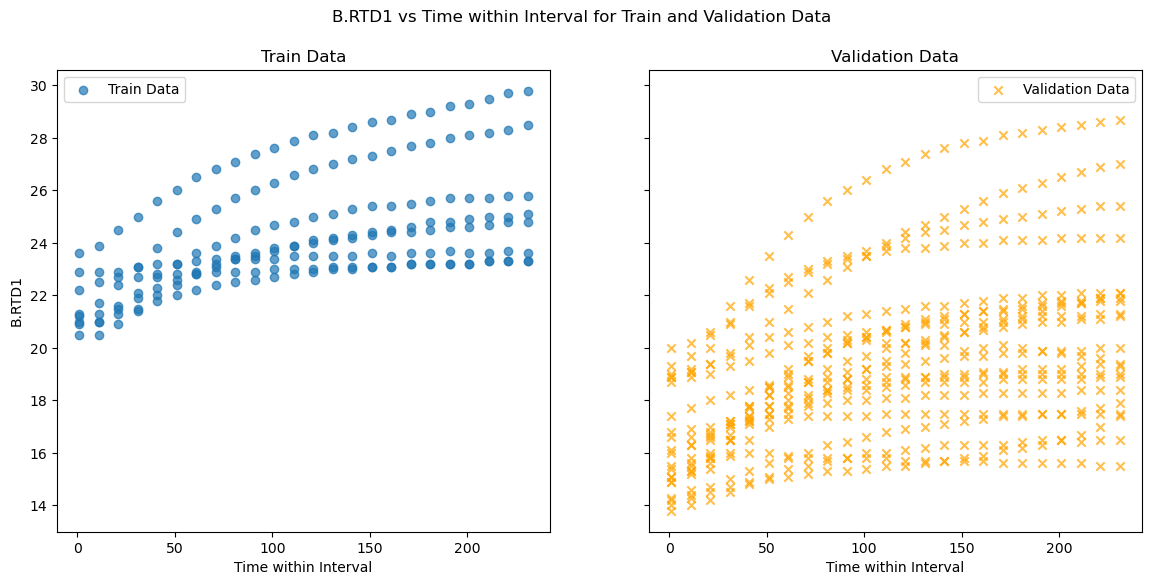

In [6]:
# Initialize lists to store train and validation data
train_time, train_heat = [], []
val_time, val_heat = [], []

# Collect data from train_loader
for batch in train_loader:
    # Extract `time_within_interval` and `B.RTD1` from each batch
    heat_obs = batch[0][:, 0].numpy()  # B.RTD1
    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale
    
    # Append to lists
    train_heat.extend(heat_obs)
    train_time.extend(time_within_interval)

# Collect data from val_loader
for batch in val_loader:
    # Extract `time_within_interval` and `B.RTD1` from each batch
    heat_obs = batch[0][:, 0].numpy()  # B.RTD1
    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale
    
    # Append to lists
    val_heat.extend(heat_obs)
    val_time.extend(time_within_interval)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot training data with markers only
axes[0].scatter(train_time, train_heat, marker='o', label="Train Data", alpha=0.7)
axes[0].set_title("Train Data")
axes[0].set_xlabel("Time within Interval")
axes[0].set_ylabel("B.RTD1")
axes[0].legend()

# Plot validation data with markers only
axes[1].scatter(val_time, val_heat, marker='x', label="Validation Data", alpha=0.7, color='orange')
axes[1].set_title("Validation Data")
axes[1].set_xlabel("Time within Interval")
axes[1].legend()

plt.suptitle("B.RTD1 vs Time within Interval for Train and Validation Data")
plt.show()


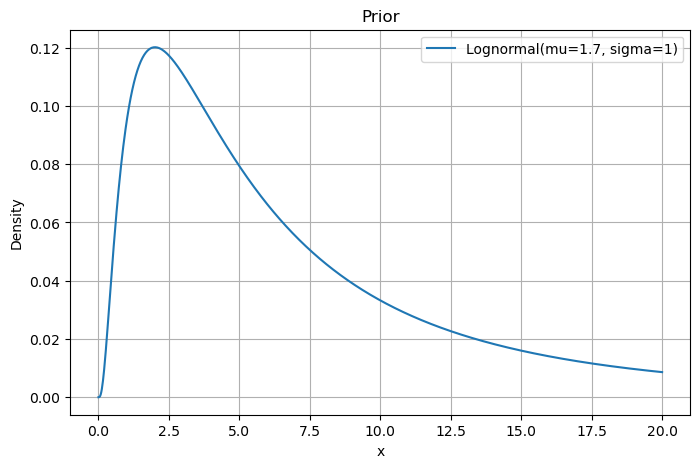

In [7]:

from scipy.stats import lognorm

def plot_single_lognormal(mu, sigma, x_range=(0.01, 20), num_points=1000):
    """
    Plot a single log-normal distribution.

    Parameters:
        mu: Mean of the underlying normal distribution.
        sigma: Standard deviation of the underlying normal distribution.
        x_range: Tuple specifying the range of x values (start, end).
        num_points: Number of points in the x range.
    """
    x = np.linspace(x_range[0], x_range[1], num_points)
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    
    plt.figure(figsize=(8, 5))
    plt.plot(x, pdf, label=f'Lognormal(mu={mu}, sigma={sigma})')
    plt.title('Prior')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_single_lognormal(mu=1.7, sigma=1)


In [8]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)) 
# kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) 

# Initialize the GP_inference
GP_inf = GP_inference(kernel)

# Initialize the VAE
torch.manual_seed(1)
model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ELU(),
                initial_alpha=1.2,# initial_alpha=1,
                trainable_alpha=True,
                mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
               )

In [9]:
gp_params = []
base_params = []
alpha_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    elif 'raw_alpha' in name:
        alpha_params.append(param)  # raw_alpha parameter(s)
    else:
        base_params.append(param)  # All other parameters

# Define learning rates for each parameter group
base_lr = 0.001     # Learning rate for base parameters
gp_lr = 0.0001      # Learning rate for GP parameters
alpha_lr = 0.0001     # Learning rate for raw_alpha
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr},
    {'params': alpha_params, 'lr': alpha_lr}
])
opt.zero_grad()


In [10]:
"""
def find_rbf_lengthscale(kernel):
    if isinstance(kernel, gpytorch.kernels.RBFKernel):
        return kernel.lengthscale.item()
    elif hasattr(kernel, 'base_kernel'):
        return find_rbf_lengthscale(kernel.base_kernel)
    elif hasattr(kernel, 'kernels'):
        for k in kernel.kernels:
            result = find_rbf_lengthscale(k)
            if result is not None:
                return result
    return None
"""

"\ndef find_rbf_lengthscale(kernel):\n    if isinstance(kernel, gpytorch.kernels.RBFKernel):\n        return kernel.lengthscale.item()\n    elif hasattr(kernel, 'base_kernel'):\n        return find_rbf_lengthscale(kernel.base_kernel)\n    elif hasattr(kernel, 'kernels'):\n        for k in kernel.kernels:\n            result = find_rbf_lengthscale(k)\n            if result is not None:\n                return result\n    return None\n"

In [11]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)


Training Progress:   5%|▍         | 48/1000 [00:02<00:54, 17.56it/s]

Epoch 50: Train Loss = 2.9976, KL_phy = 3.0149, KL_delta = -0.4434, MSE = 2.7097, CE = 1.5850, Reg_Loss = 0.0258, Alpha = 1.1945
Validation Loss = 3.5895, Val_KL_phy = 3.0478, Val_KL_delta = -0.4451, Val_MSE = 3.2395, Val_CE = 1.5322, Val_Reg_Loss = 0.0751, Val_Alpha = 1.1945


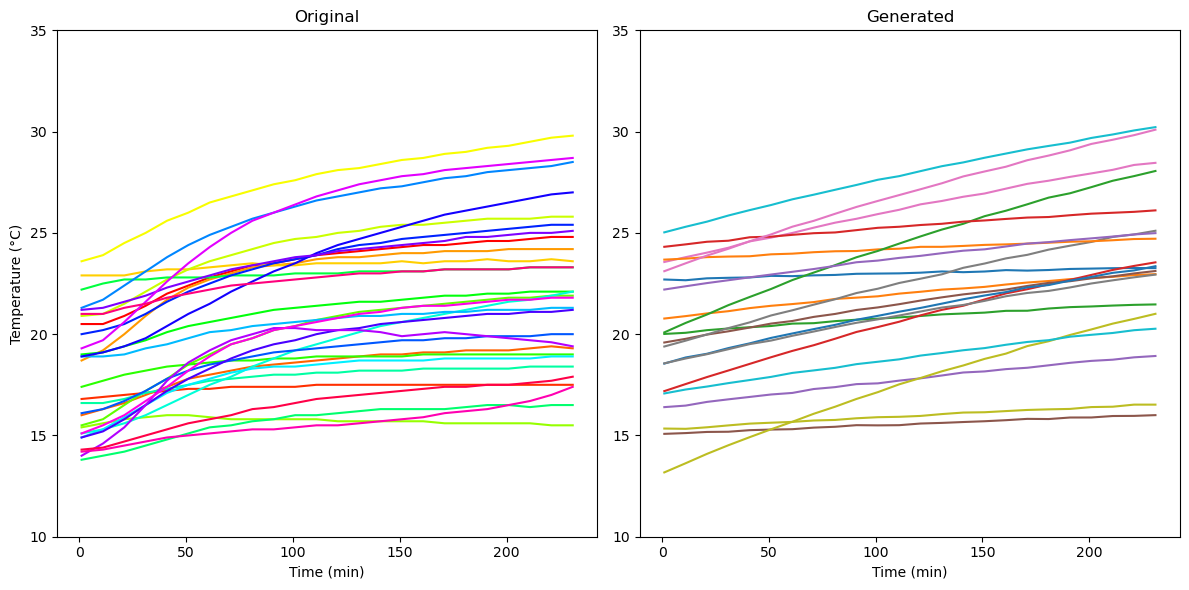

Training Progress:  10%|▉         | 98/1000 [00:06<00:52, 17.28it/s]

Epoch 100: Train Loss = 2.8345, KL_phy = 2.8823, KL_delta = -0.4289, MSE = 2.5762, CE = 1.5346, Reg_Loss = 0.0108, Alpha = 1.1896
Validation Loss = 2.7979, Val_KL_phy = 2.9067, Val_KL_delta = -0.4355, Val_MSE = 2.5108, Val_CE = 1.4943, Val_Reg_Loss = 0.0336, Val_Alpha = 1.1895


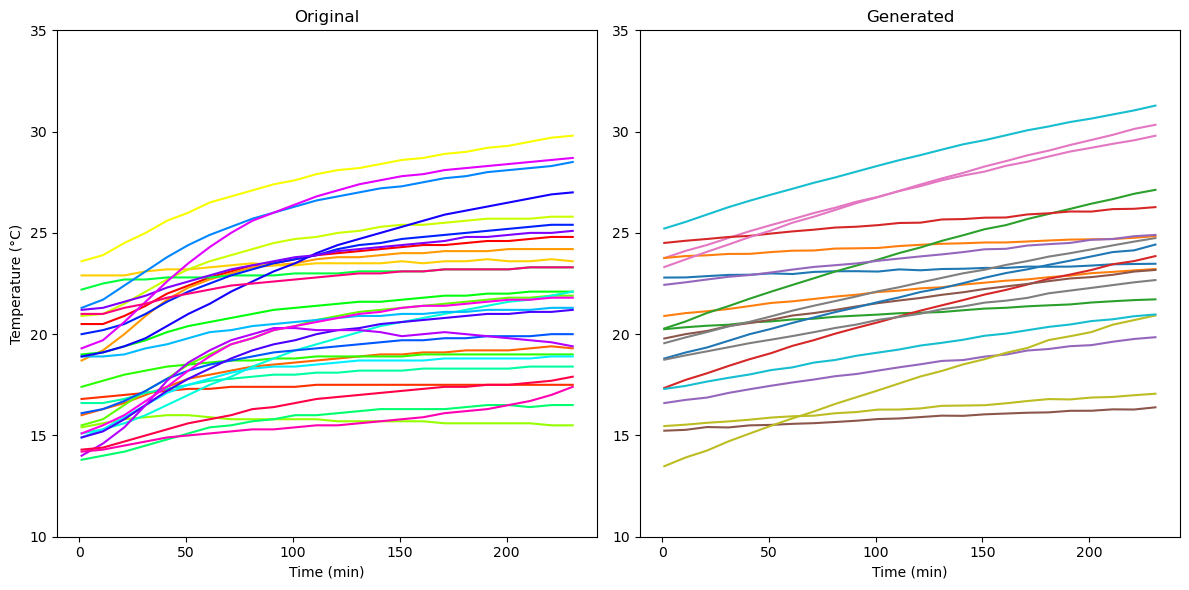

Training Progress:  15%|█▍        | 148/1000 [00:09<00:49, 17.32it/s]

Epoch 150: Train Loss = 2.8034, KL_phy = 2.7860, KL_delta = -0.4264, MSE = 2.5443, CE = 1.6014, Reg_Loss = 0.0196, Alpha = 1.1835
Validation Loss = 2.9660, Val_KL_phy = 2.8429, Val_KL_delta = -0.4356, Val_MSE = 2.6773, Val_CE = 1.5481, Val_Reg_Loss = 0.0405, Val_Alpha = 1.1834


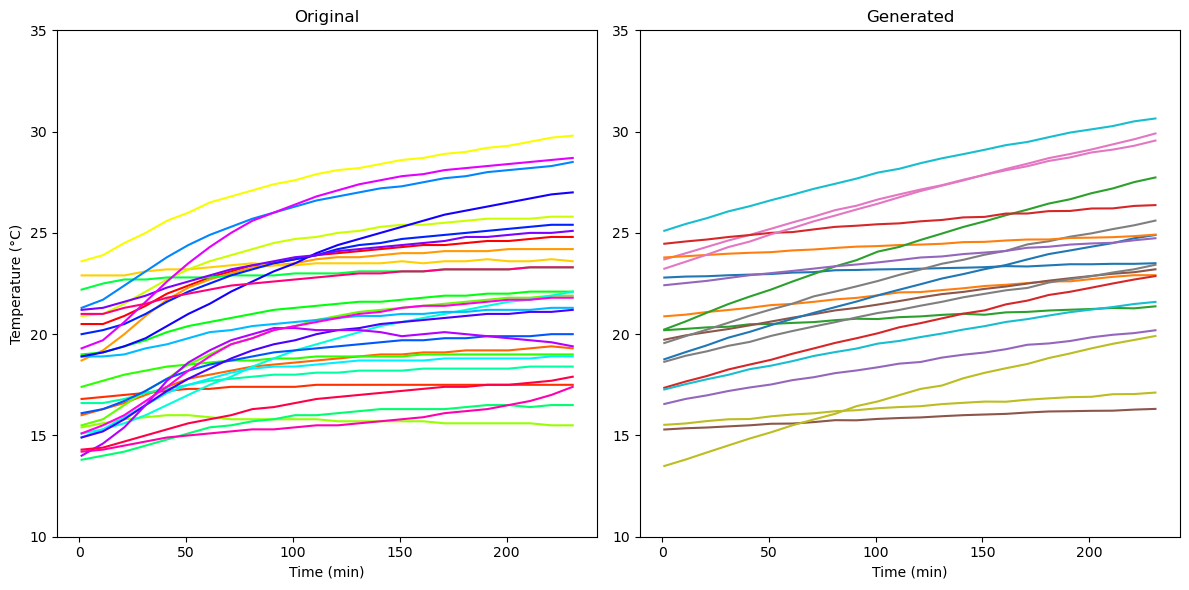

Training Progress:  20%|█▉        | 198/1000 [00:12<00:46, 17.28it/s]

Epoch 200: Train Loss = 2.7265, KL_phy = 2.8352, KL_delta = -0.4125, MSE = 2.4666, CE = 1.4532, Reg_Loss = 0.0150, Alpha = 1.1743
Validation Loss = 2.7310, Val_KL_phy = 2.8751, Val_KL_delta = -0.4235, Val_MSE = 2.4603, Val_CE = 1.4263, Val_Reg_Loss = 0.0218, Val_Alpha = 1.1742


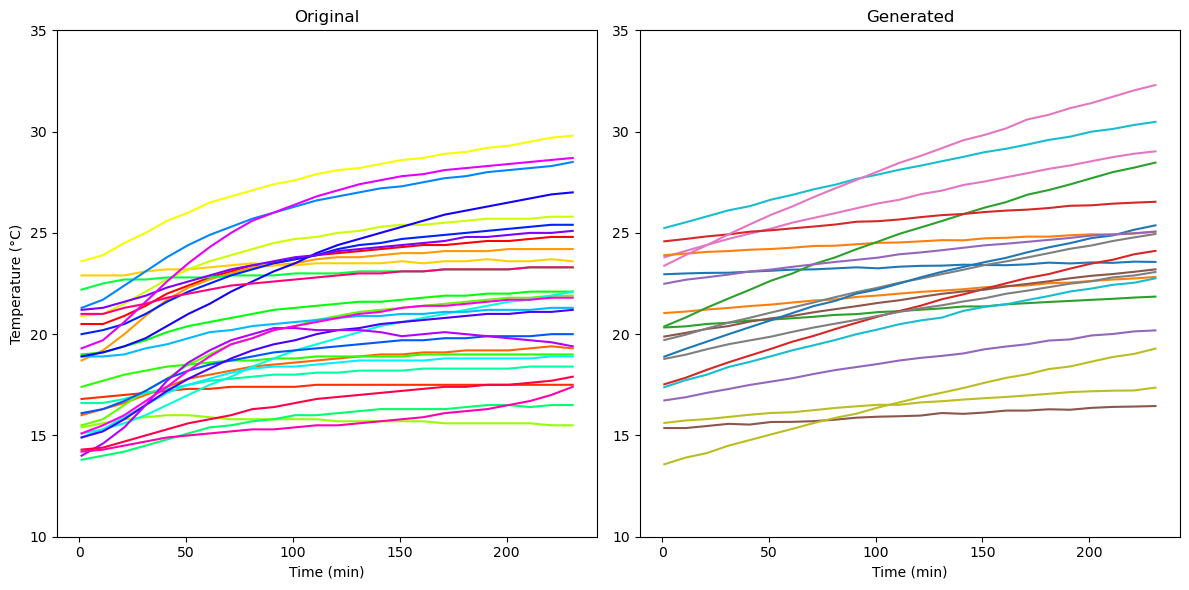

Training Progress:  25%|██▍       | 248/1000 [00:15<00:45, 16.42it/s]

Epoch 250: Train Loss = 2.6186, KL_phy = 2.7951, KL_delta = -0.3855, MSE = 2.3600, CE = 1.2172, Reg_Loss = 0.0152, Alpha = 1.1615
Validation Loss = 2.8467, Val_KL_phy = 2.8588, Val_KL_delta = -0.4039, Val_MSE = 2.5773, Val_CE = 1.2248, Val_Reg_Loss = 0.0206, Val_Alpha = 1.1614


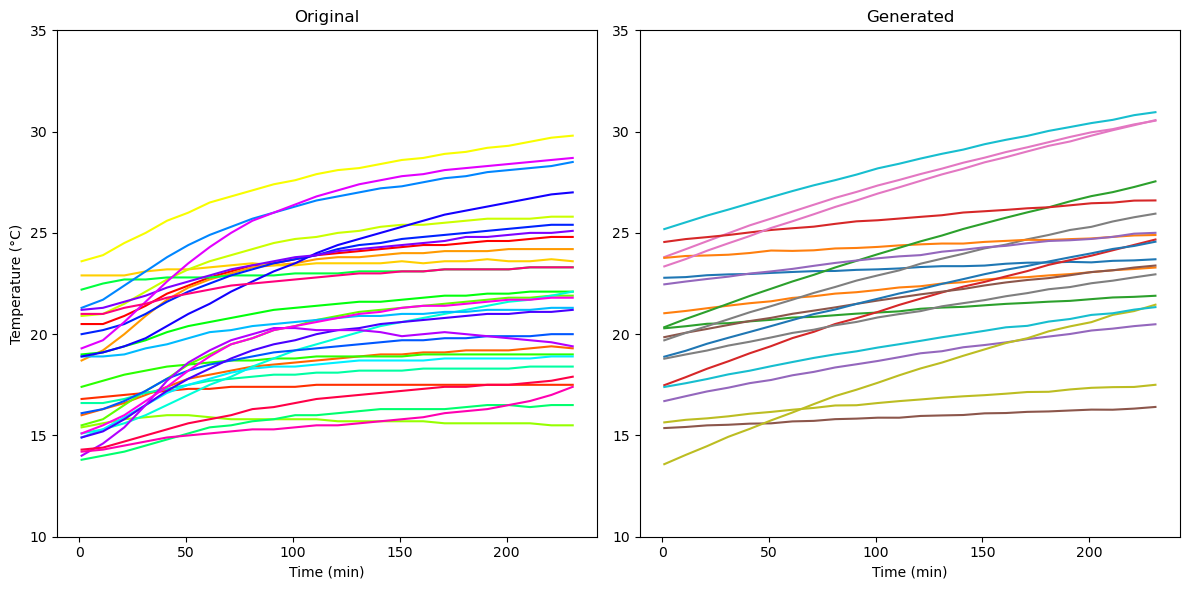

Training Progress:  30%|██▉       | 298/1000 [00:18<00:40, 17.17it/s]

Epoch 300: Train Loss = 2.4533, KL_phy = 2.7944, KL_delta = -0.3844, MSE = 2.1956, CE = 1.1836, Reg_Loss = 0.0145, Alpha = 1.1487
Validation Loss = 2.8736, Val_KL_phy = 2.8822, Val_KL_delta = -0.4028, Val_MSE = 2.6010, Val_CE = 1.1906, Val_Reg_Loss = 0.0215, Val_Alpha = 1.1486


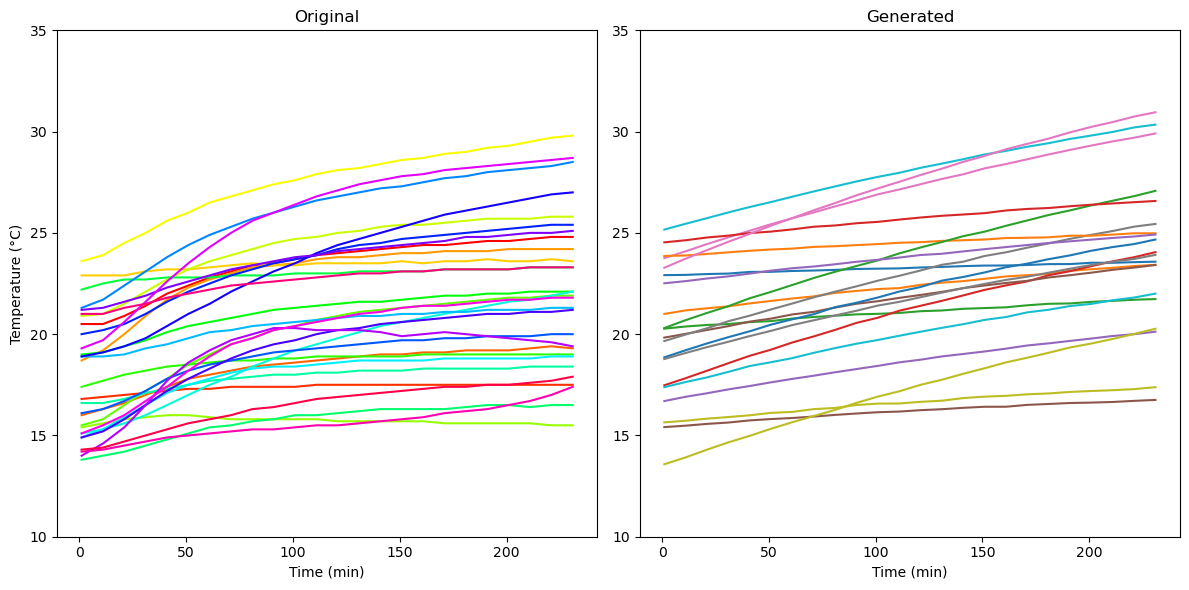

Training Progress:  35%|███▍      | 348/1000 [00:21<00:37, 17.28it/s]

Epoch 350: Train Loss = 2.3976, KL_phy = 2.8190, KL_delta = -0.3712, MSE = 2.1292, CE = 1.1794, Reg_Loss = 0.0209, Alpha = 1.1331
Validation Loss = 2.6902, Val_KL_phy = 2.9016, Val_KL_delta = -0.3942, Val_MSE = 2.4054, Val_CE = 1.2031, Val_Reg_Loss = 0.0301, Val_Alpha = 1.1329


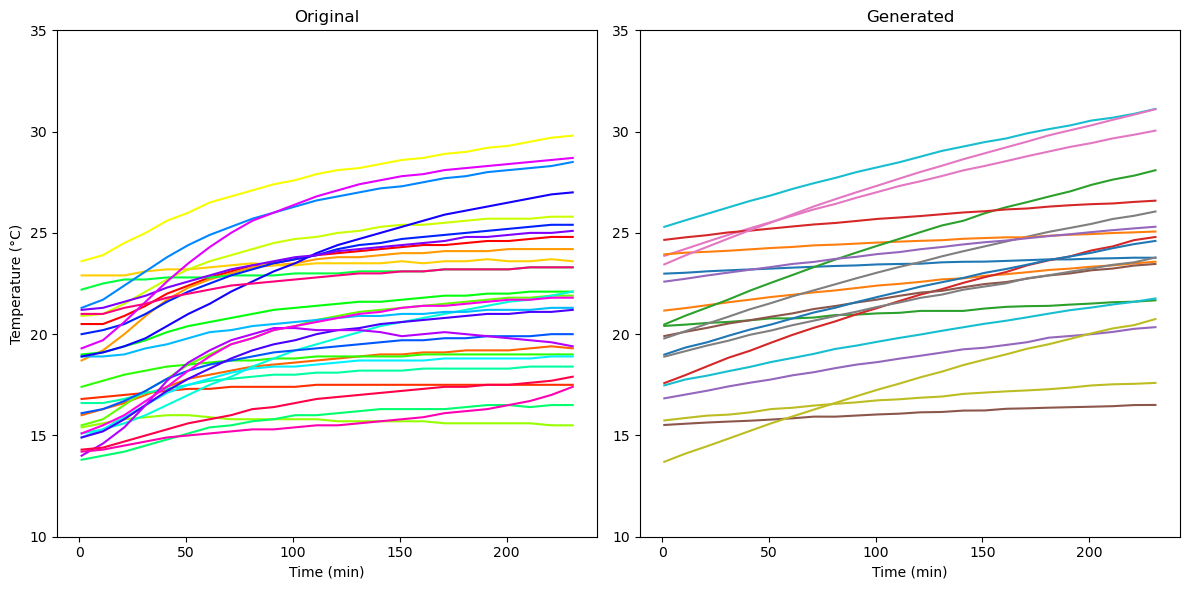

Training Progress:  40%|███▉      | 398/1000 [00:24<00:35, 17.09it/s]

Epoch 400: Train Loss = 3.0994, KL_phy = 2.8905, KL_delta = -0.3420, MSE = 2.8209, CE = 0.9737, Reg_Loss = 0.0213, Alpha = 1.1148
Validation Loss = 2.6616, Val_KL_phy = 2.9993, Val_KL_delta = -0.3734, Val_MSE = 2.3608, Val_CE = 1.0403, Val_Reg_Loss = 0.0343, Val_Alpha = 1.1147


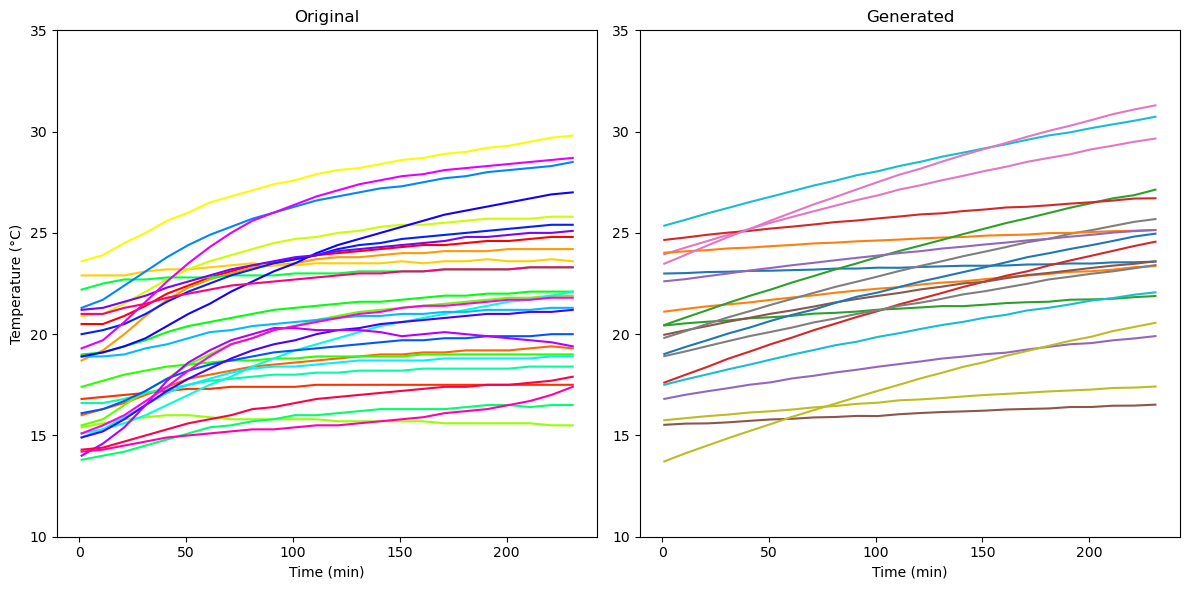

Training Progress:  45%|████▍     | 448/1000 [00:27<00:32, 16.98it/s]

Epoch 450: Train Loss = 2.7750, KL_phy = 2.8066, KL_delta = -0.2865, MSE = 2.4913, CE = 0.9284, Reg_Loss = 0.0289, Alpha = 1.0949
Validation Loss = 2.6972, Val_KL_phy = 2.9636, Val_KL_delta = -0.3451, Val_MSE = 2.4045, Val_CE = 1.0050, Val_Reg_Loss = 0.0282, Val_Alpha = 1.0947


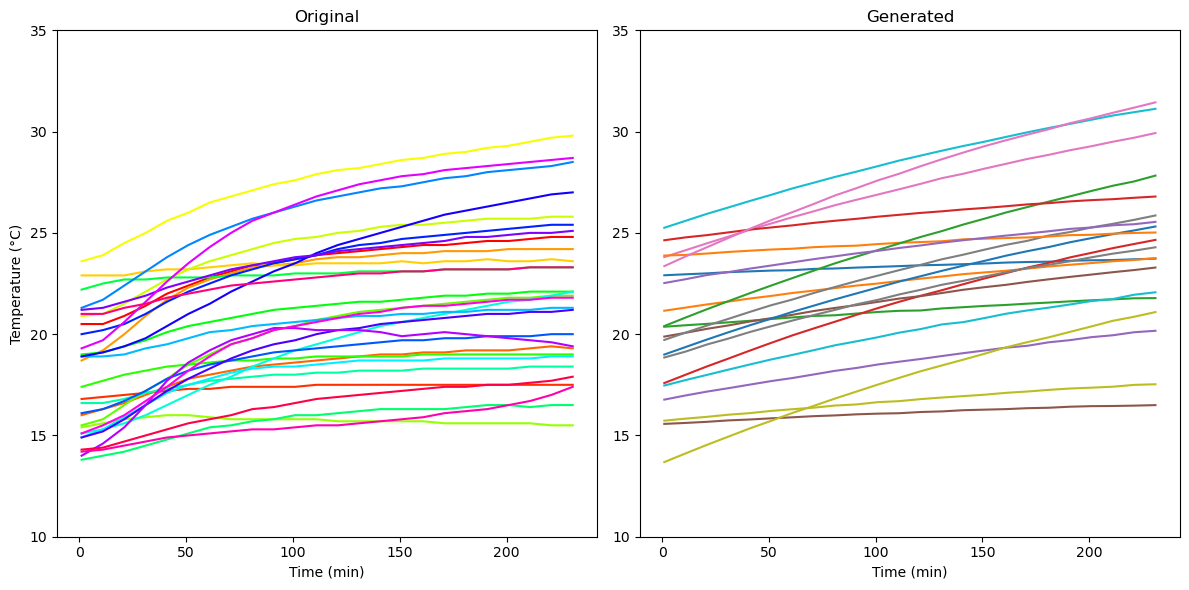

Training Progress:  50%|████▉     | 498/1000 [00:30<00:29, 16.93it/s]

Epoch 500: Train Loss = 2.6236, KL_phy = 2.8854, KL_delta = -0.2175, MSE = 2.3341, CE = 0.7695, Reg_Loss = 0.0212, Alpha = 1.0707
Validation Loss = 2.6097, Val_KL_phy = 3.0444, Val_KL_delta = -0.3004, Val_MSE = 2.2974, Val_CE = 0.8942, Val_Reg_Loss = 0.0354, Val_Alpha = 1.0705


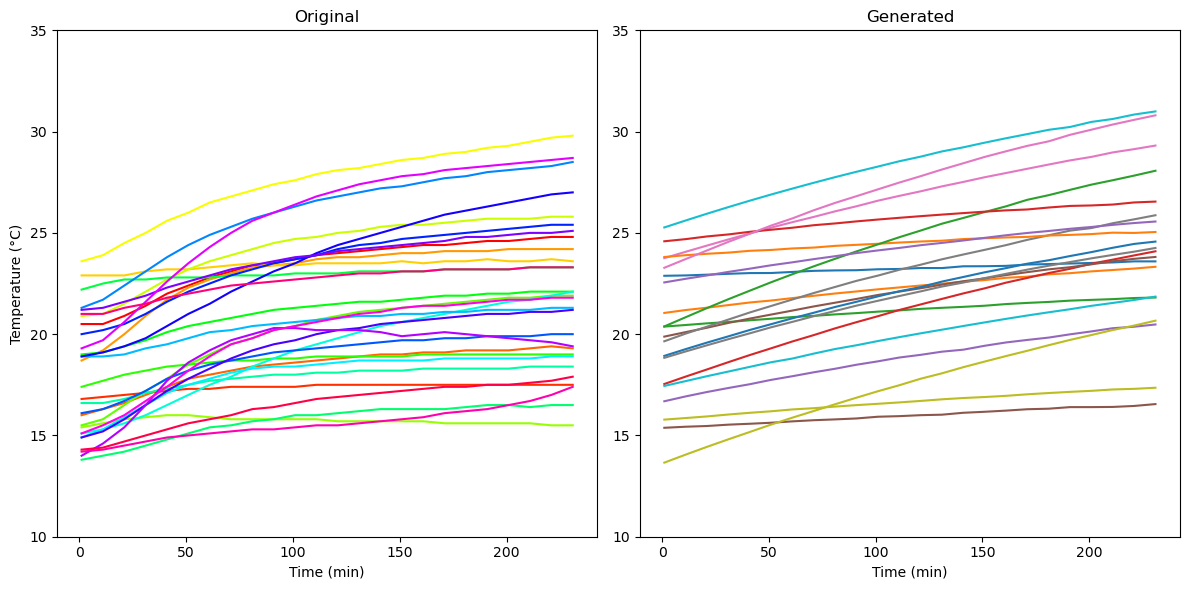

Training Progress:  55%|█████▍    | 548/1000 [00:33<00:27, 16.57it/s]/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Epoch 550: Train Loss = 2.6399, KL_phy = 2.7873, KL_delta = -0.0864, MSE = 2.3218, CE = 0.5770, Reg_Loss = 0.0460, Alpha = 1.0444
Validation Loss = 2.5745, Val_KL_phy = 2.9904, Val_KL_delta = -0.2223, Val_MSE = 2.2421, Val_CE = 0.7330, Val_Reg_Loss = 0.0532, Val_Alpha = 1.0441


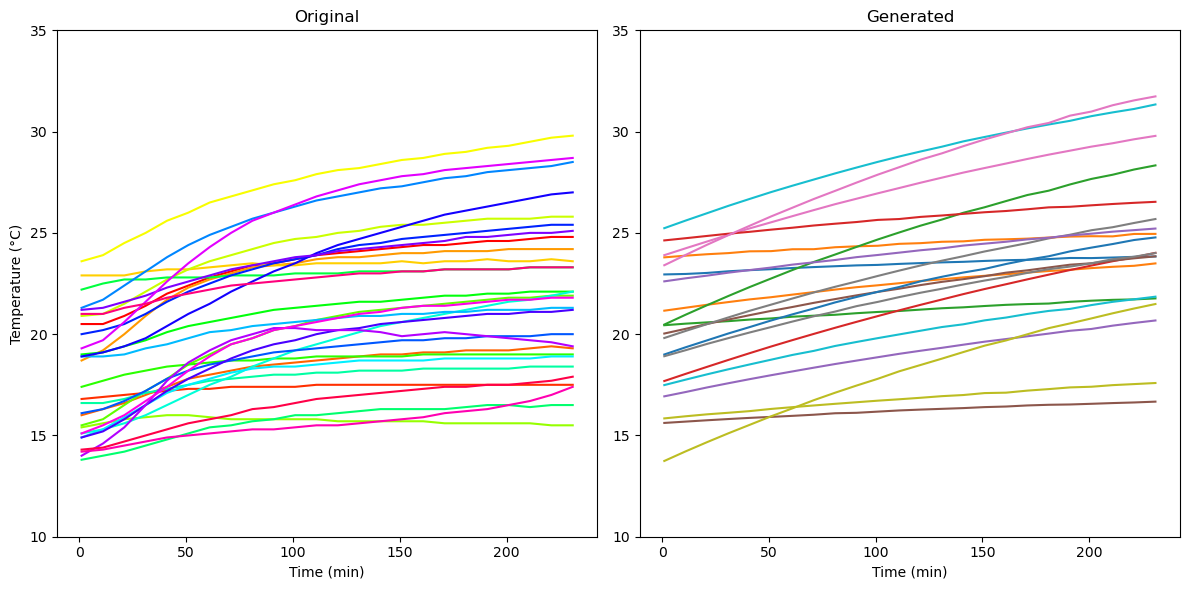

Training Progress:  60%|█████▉    | 598/1000 [00:36<00:24, 16.51it/s]

Epoch 600: Train Loss = 2.4560, KL_phy = 2.7847, KL_delta = 0.0906, MSE = 2.1254, CE = 0.2674, Reg_Loss = 0.0425, Alpha = 1.0145
Validation Loss = 2.9289, Val_KL_phy = 3.0118, Val_KL_delta = -0.1140, Val_MSE = 2.5811, Val_CE = 0.4949, Val_Reg_Loss = 0.0572, Val_Alpha = 1.0142


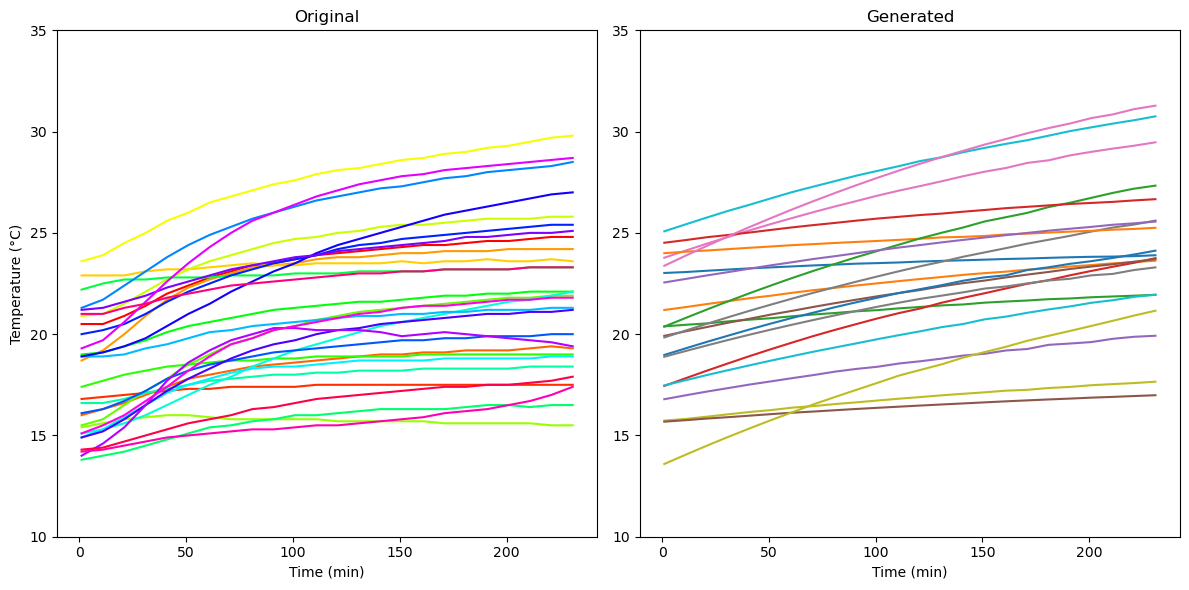

Training Progress:  65%|██████▍   | 648/1000 [00:40<00:20, 16.95it/s]

Epoch 650: Train Loss = 2.7939, KL_phy = 2.8891, KL_delta = 0.3378, MSE = 2.3601, CE = 0.1857, Reg_Loss = 0.1137, Alpha = 0.9778
Validation Loss = 2.7346, Val_KL_phy = 3.1188, Val_KL_delta = 0.0843, Val_MSE = 2.3255, Val_CE = 0.3716, Val_Reg_Loss = 0.0908, Val_Alpha = 0.9774


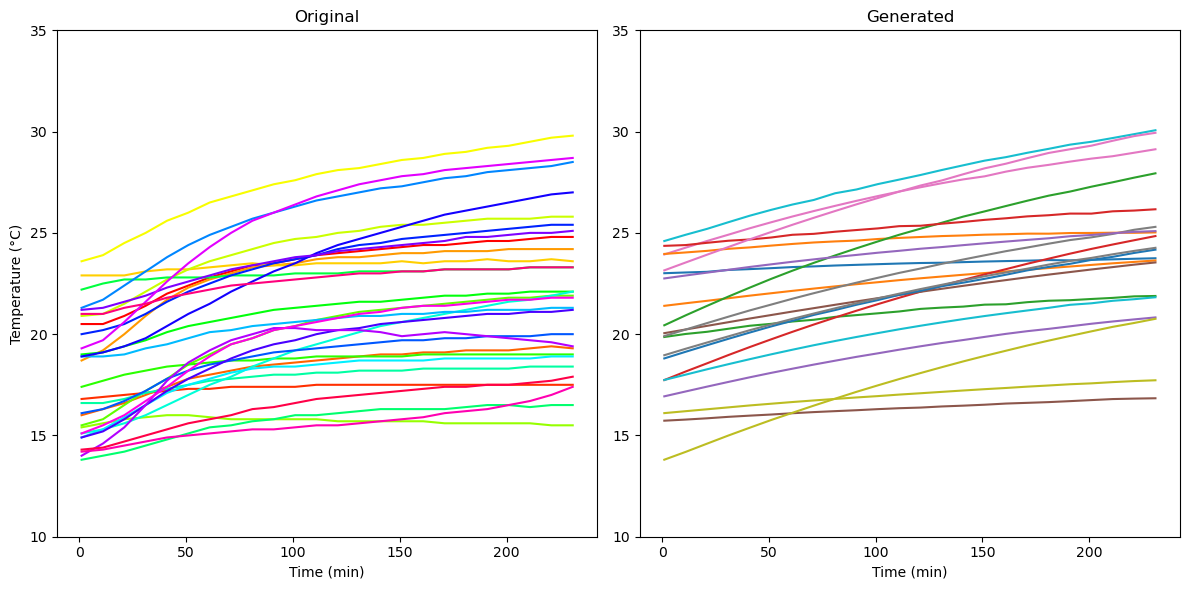

Training Progress:  70%|██████▉   | 698/1000 [00:43<00:19, 15.37it/s]

Epoch 700: Train Loss = 2.1219, KL_phy = 2.8192, KL_delta = 0.7222, MSE = 1.6509, CE = 0.1700, Reg_Loss = 0.1244, Alpha = 0.9390
Validation Loss = 2.6019, Val_KL_phy = 3.0832, Val_KL_delta = 0.3177, Val_MSE = 2.1067, Val_CE = 0.3830, Val_Reg_Loss = 0.1652, Val_Alpha = 0.9386


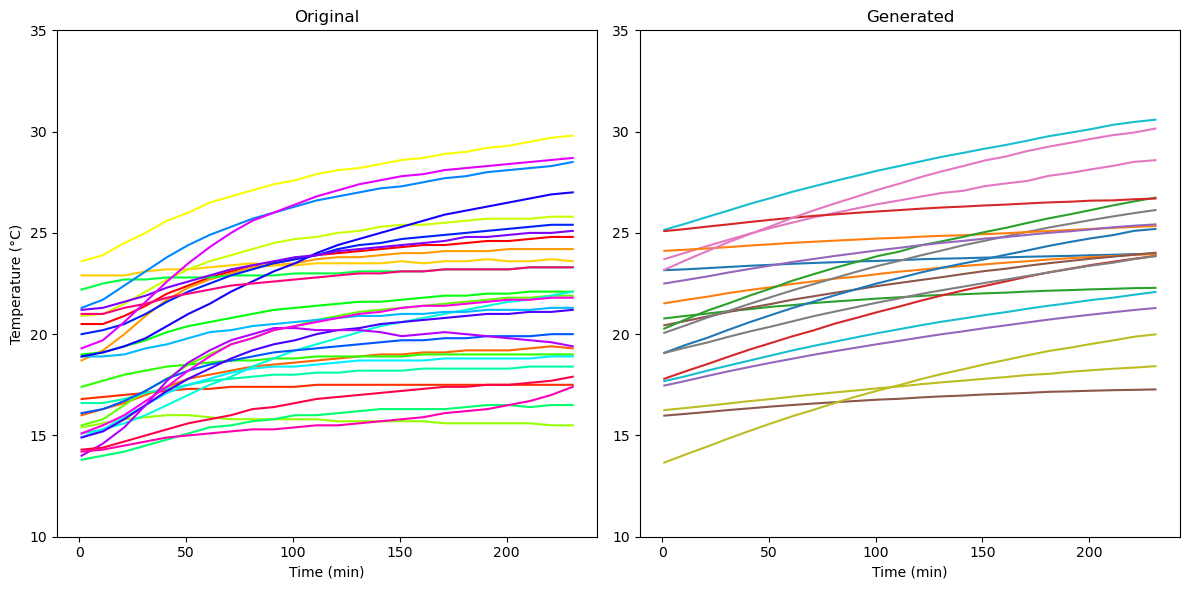

Training Progress:  75%|███████▍  | 749/1000 [00:47<00:16, 15.49it/s]

Epoch 750: Train Loss = 1.9701, KL_phy = 2.7463, KL_delta = 1.1277, MSE = 1.3937, CE = 0.0523, Reg_Loss = 0.2094, Alpha = 0.9026
Validation Loss = 2.3647, Val_KL_phy = 3.0028, Val_KL_delta = 0.5954, Val_MSE = 1.7704, Val_CE = 0.2476, Val_Reg_Loss = 0.2598, Val_Alpha = 0.9023


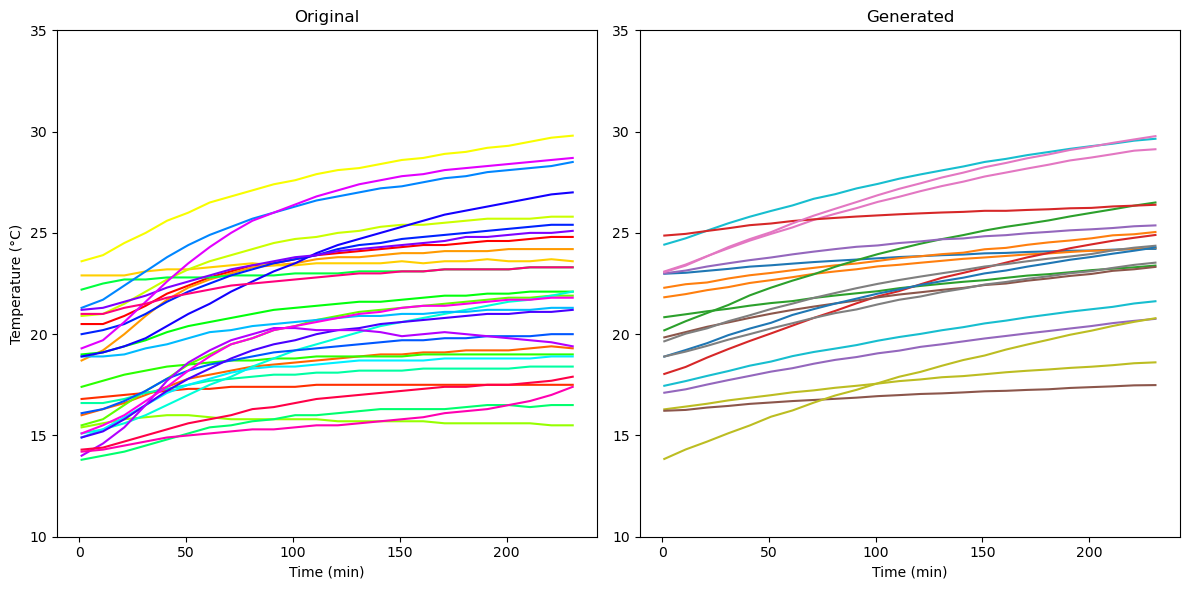

Training Progress:  80%|███████▉  | 799/1000 [00:50<00:12, 16.69it/s]

Epoch 800: Train Loss = 1.9374, KL_phy = 2.7494, KL_delta = 1.4183, MSE = 1.1964, CE = 0.0576, Reg_Loss = 0.3722, Alpha = 0.8712
Validation Loss = 2.6443, Val_KL_phy = 3.0670, Val_KL_delta = 0.7594, Val_MSE = 1.9453, Val_CE = 0.1877, Val_Reg_Loss = 0.3633, Val_Alpha = 0.8709


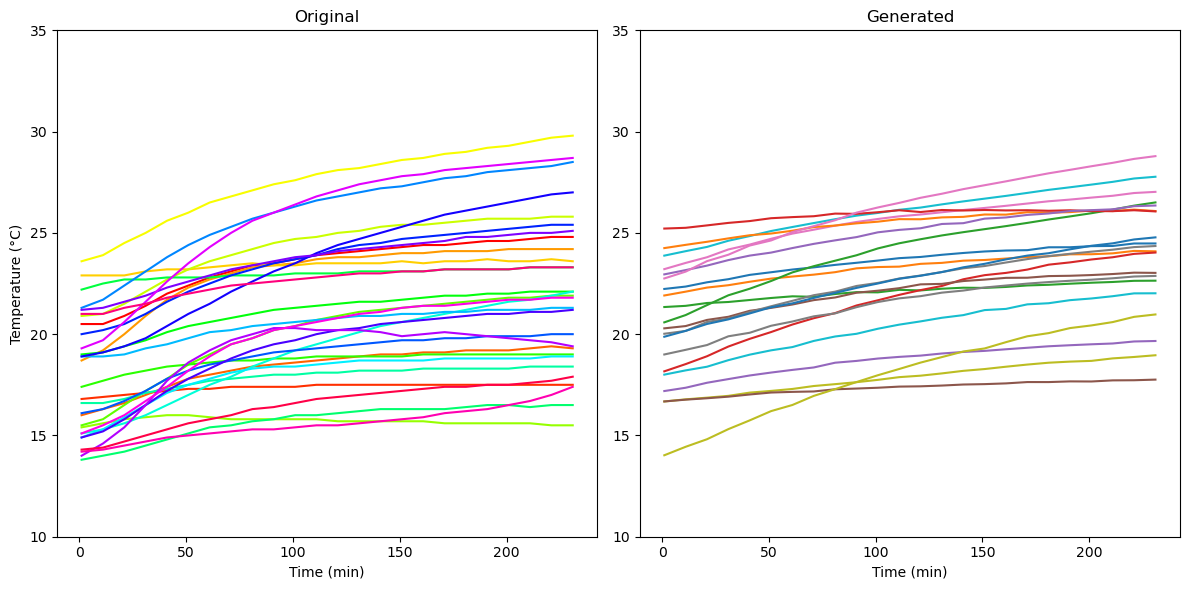

Training Progress:  85%|████████▍ | 849/1000 [00:54<00:09, 15.96it/s]

Epoch 850: Train Loss = 2.0041, KL_phy = 2.7777, KL_delta = 1.6057, MSE = 1.1652, CE = 0.0929, Reg_Loss = 0.4757, Alpha = 0.8421
Validation Loss = 2.9348, Val_KL_phy = 3.1136, Val_KL_delta = 0.8599, Val_MSE = 2.0838, Val_CE = 0.1749, Val_Reg_Loss = 0.5388, Val_Alpha = 0.8419


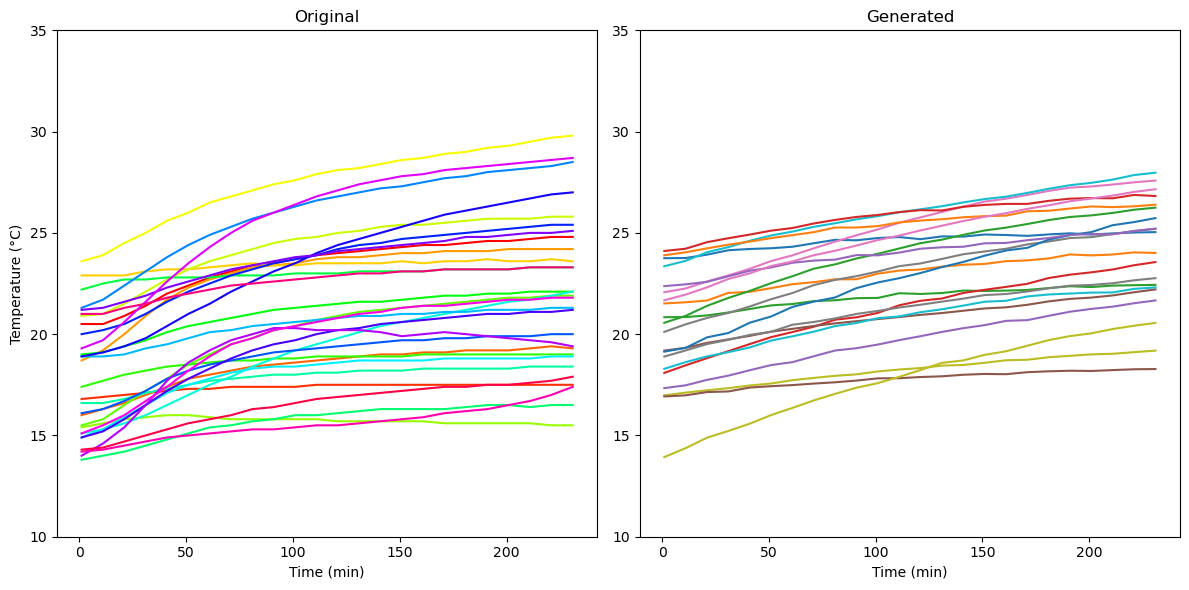

Training Progress:  90%|████████▉ | 899/1000 [00:57<00:06, 16.59it/s]

Epoch 900: Train Loss = 1.7933, KL_phy = 2.9713, KL_delta = 1.6383, MSE = 0.8845, CE = 0.0790, Reg_Loss = 0.5484, Alpha = 0.8166
Validation Loss = 2.3430, Val_KL_phy = 3.2997, Val_KL_delta = 0.9157, Val_MSE = 1.4897, Val_CE = 0.1757, Val_Reg_Loss = 0.5289, Val_Alpha = 0.8164


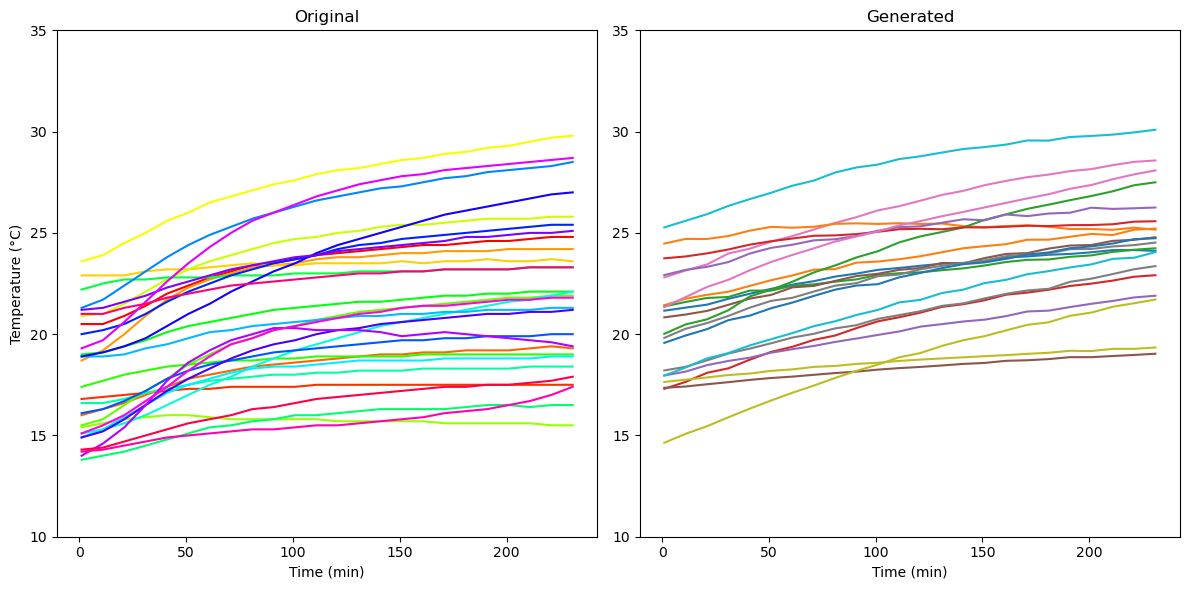

Training Progress:  95%|█████████▍| 949/1000 [01:00<00:03, 16.53it/s]

Epoch 950: Train Loss = 1.5570, KL_phy = 2.7912, KL_delta = 1.5472, MSE = 0.7072, CE = 0.0702, Reg_Loss = 0.5238, Alpha = 0.7941
Validation Loss = 2.3886, Val_KL_phy = 3.1784, Val_KL_delta = 0.8553, Val_MSE = 1.5713, Val_CE = 0.1763, Val_Reg_Loss = 0.5213, Val_Alpha = 0.7939


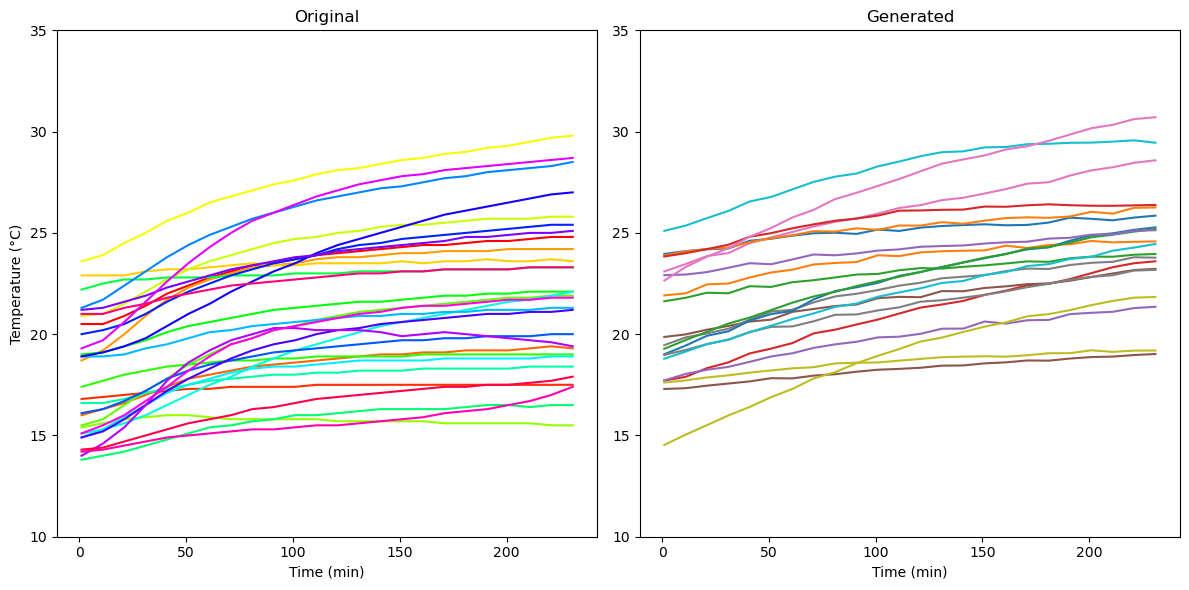

Training Progress: 100%|█████████▉| 999/1000 [01:04<00:00, 14.85it/s]

Epoch 1000: Train Loss = 1.6918, KL_phy = 2.8686, KL_delta = 1.4527, MSE = 0.7600, CE = 0.0680, Reg_Loss = 0.6451, Alpha = 0.7746
Validation Loss = 2.3210, Val_KL_phy = 3.2565, Val_KL_delta = 0.7957, Val_MSE = 1.5378, Val_CE = 0.1822, Val_Reg_Loss = 0.4881, Val_Alpha = 0.7744


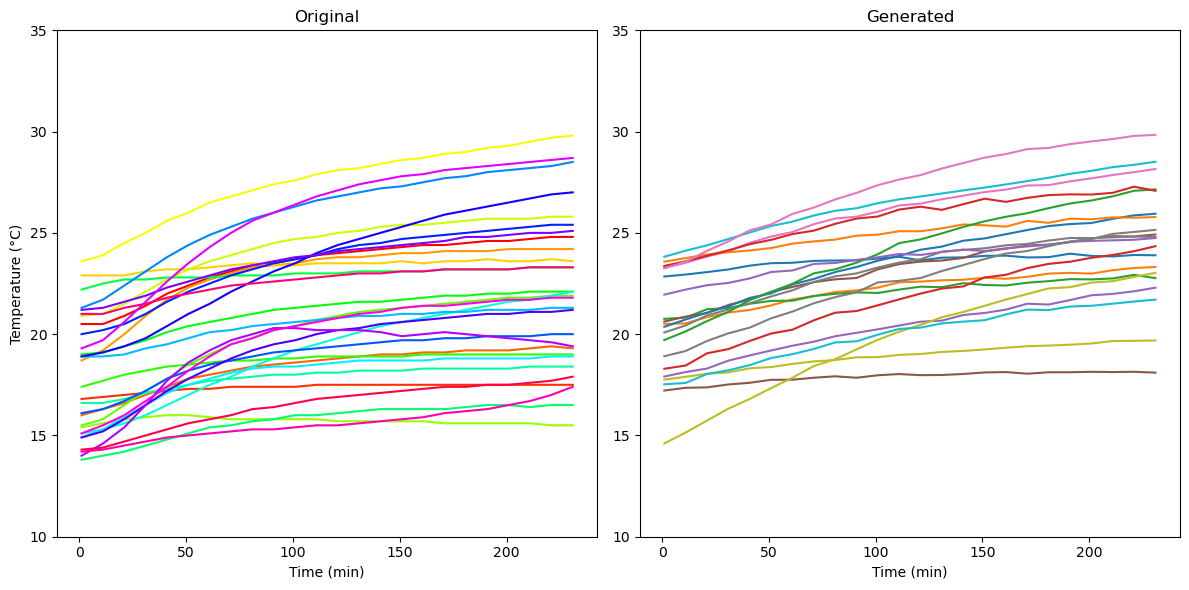

Training Progress: 100%|██████████| 1000/1000 [01:04<00:00, 15.49it/s]


In [12]:
num_epochs=1000
epochs=range(num_epochs)

annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.1, 
                                       beta_max=0.1)
beta_annealed = annealing_strategy.get_beta_vector()

beta_delta=beta_annealed
beta_phy=beta_annealed
ns = 20
min_T, max_T = 12, 25
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)

fit_res = model.fit(train_loader=train_loader, 
                    val_loader=val_loader, 
                    opt=opt, 
                    beta_delta=beta_delta,
                    beta_phy=beta_phy,
                    num_epochs=num_epochs,
                   seed=0, plot=True, df=df_h, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(10, 35))


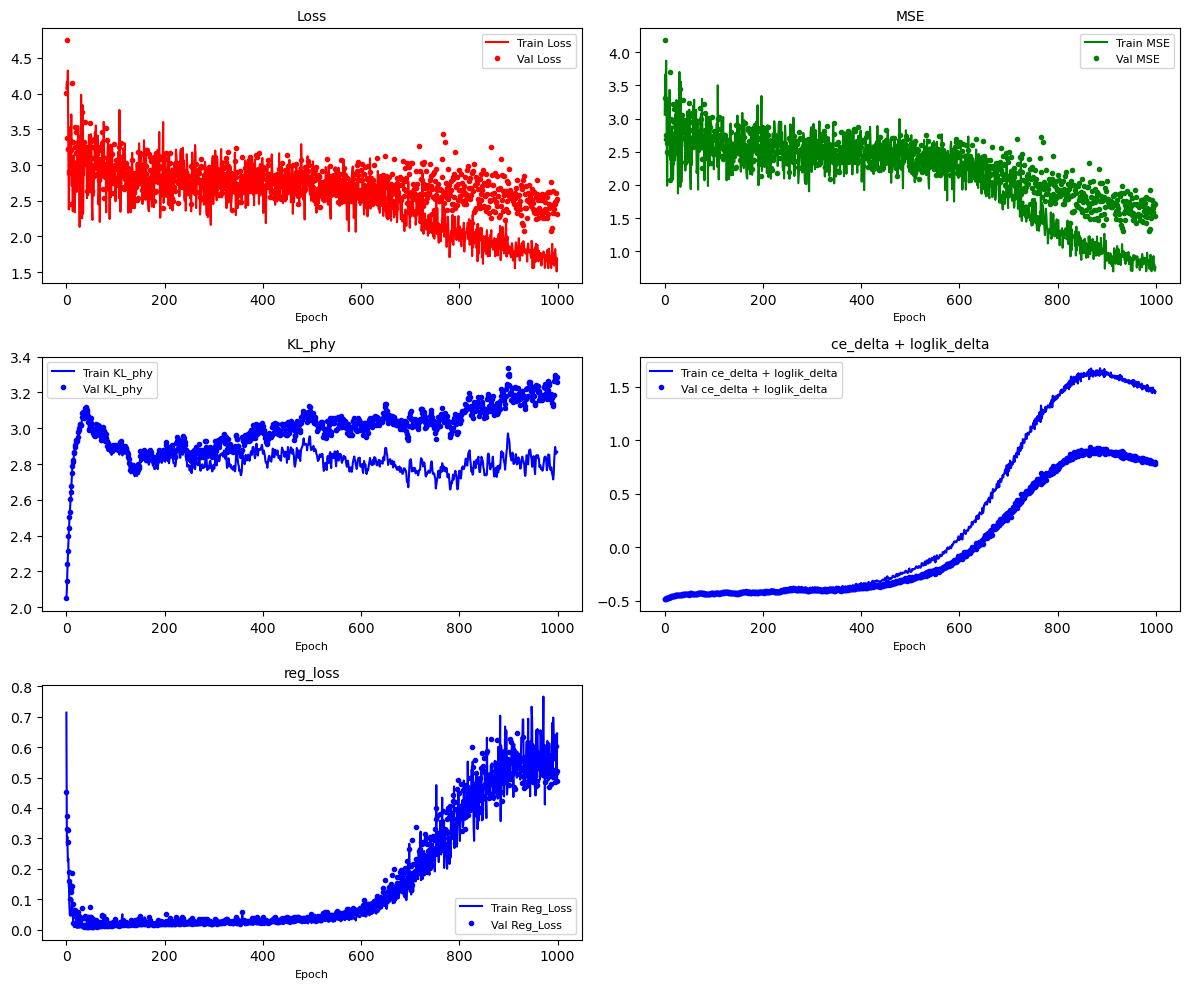

In [13]:
# Extract quantities for plotting
epochs = fit_res['epochs']
l_loss = fit_res['train_loss']
val_loss = fit_res['val_loss']
mse = fit_res['train_mse']
val_mse = fit_res['val_mse']
KL_phy = fit_res['train_KL_phy']
val_KL_phy = fit_res['val_KL_phy']
KL_delta = fit_res['train_KL_delta']
val_KL_delta = fit_res['val_KL_delta']
reg_loss = fit_res['train_reg_loss']
val_reg_loss = fit_res['val_reg_loss']

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # Keeping original figure size

# Loss plot (train vs. validation)
axs[0, 0].plot(epochs, l_loss, 'r-', label='Train Loss')
axs[0, 0].plot(epochs, val_loss, 'ro', label='Val Loss', markersize=3)  # Only points for validation
axs[0, 0].set_title('Loss', fontsize=10)
axs[0, 0].set_xlabel('Epoch', fontsize=8)
axs[0, 0].legend(fontsize=8)

# MSE plot (train vs. validation)
axs[0, 1].plot(epochs, mse, 'g-', label='Train MSE')
axs[0, 1].plot(epochs, val_mse, 'go', label='Val MSE', markersize=3)  # Only points for validation
axs[0, 1].set_title('MSE', fontsize=10)
axs[0, 1].set_xlabel('Epoch', fontsize=8)
axs[0, 1].legend(fontsize=8)

# KL Divergence (train vs. validation)
axs[1, 0].plot(epochs, KL_phy, 'b-', label='Train KL_phy')
axs[1, 0].plot(epochs, val_KL_phy, 'bo', label='Val KL_phy', markersize=3)  # Only points for validation
axs[1, 0].set_title('KL_phy', fontsize=10)
axs[1, 0].set_xlabel('Epoch', fontsize=8)
axs[1, 0].legend(fontsize=8)

# KL_delta + loglik_delta (train vs. validation)
axs[1, 1].plot(epochs, KL_delta, 'b-', label='Train ce_delta + loglik_delta')
axs[1, 1].plot(epochs, val_KL_delta, 'bo', label='Val ce_delta + loglik_delta', markersize=3)  # Only points for validation
axs[1, 1].set_title('ce_delta + loglik_delta', fontsize=10)
axs[1, 1].set_xlabel('Epoch', fontsize=8)
axs[1, 1].legend(fontsize=8)

# Regularization loss (train vs. validation) - Spanning entire third row
axs[2, 0].plot(epochs, reg_loss, 'b-', label='Train Reg_Loss')
axs[2, 0].plot(epochs, val_reg_loss, 'bo', label='Val Reg_Loss', markersize=3)  # Only points for validation
axs[2, 0].set_title('reg_loss', fontsize=10)
axs[2, 0].set_xlabel('Epoch', fontsize=8)
axs[2, 0].legend(fontsize=8)

# Remove empty subplot (since we have 5 plots, and this grid would have 6 subplots)
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [40]:
q_mu_delta_l, q_var_delta_l, q_mu_phy_l, q_var_phy_l, x_hat_l, x_hat_phy_l, x_hat_delta_l, = [], [], [], [], [], [], []
batches_data = []
# Iterate through the train_loader to obtain x_batch
for x_batch in train_loader:
    with torch.no_grad():
        x_batch = x_batch.squeeze(0)  

        x_hat_i, x_hat_phy_i, x_hat_delta_i, _, _, _, q_mu_delta_i, q_var_delta_i, q_mu_phy_i, q_var_phy_i = model(x_batch)

        q_mu_delta_l.append(q_mu_delta_i)
        q_var_delta_l.append(q_var_delta_i)
        q_mu_phy_l.append(q_mu_phy_i)
        q_var_phy_l.append(q_var_phy_i)
        x_hat_l.append(x_hat_i)
        x_hat_phy_l.append(x_hat_phy_i)
        x_hat_delta_l.append(x_hat_delta_i)
        batches_data.append(x_batch)
        
mean_q_mu_phy = sum(q_mu_phy_l) / len(q_mu_phy_l)
mean_q_var_phy = sum(q_var_phy_l) / len(q_var_phy_l)
mu_s = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)


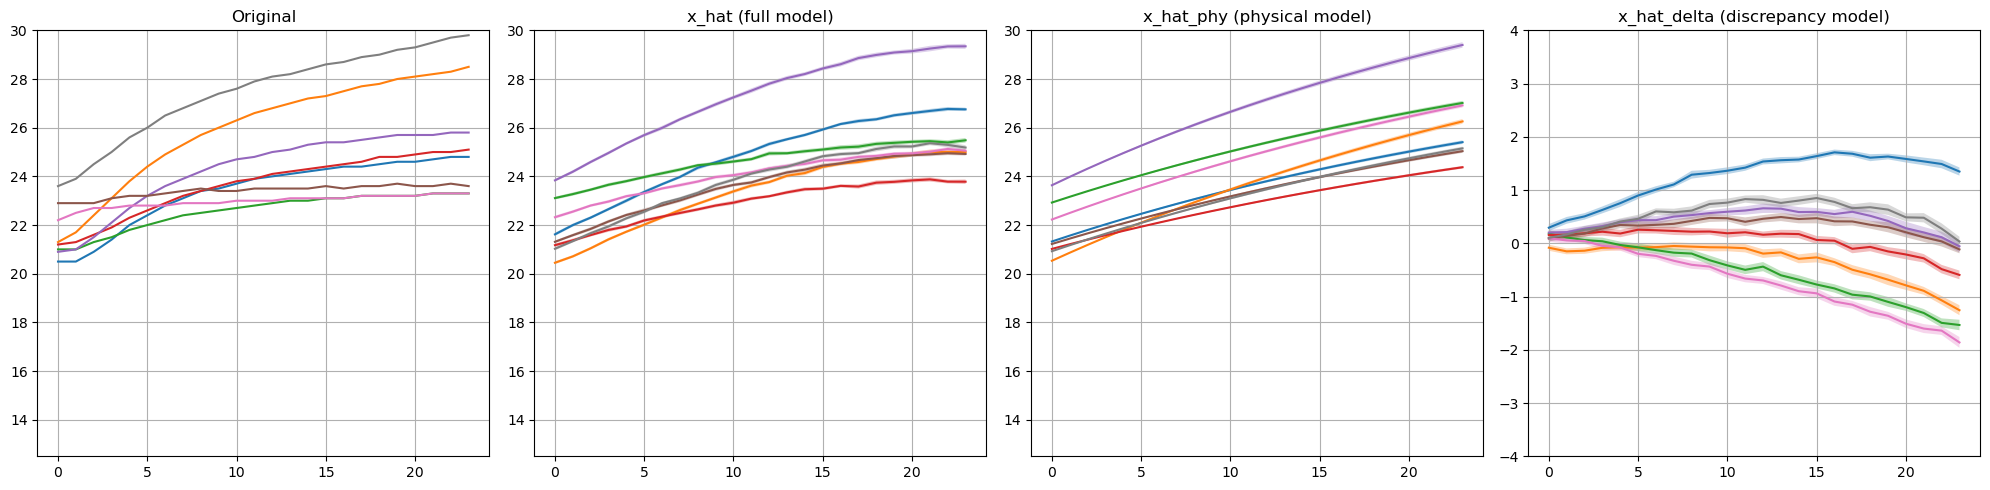

In [41]:
x_hat_numpy = [x_hat_l[sa].numpy() for sa in range(len(x_hat_l))]
batches_data_numpy = [batches_data[sa][:, 0].unsqueeze(1).numpy() for sa in range(len(batches_data))]
x_hat_phy_numpy = [x_hat_phy_l[sa].numpy() for sa in range(len(x_hat_phy_l))]
x_hat_delta_numpy = [x_hat_delta_l[sa].numpy() for sa in range(len(x_hat_delta_l))]

# Number of subplots is the length of the lists (assuming all have the same length)
num_plots = len(x_hat_numpy)

# Function to compute mean and 95% CI
def compute_mean_and_ci(samples):
    samples = np.array(samples)  # Ensure it's a NumPy array
    mean = np.mean(samples, axis=0)  # Mean across samples
    std = np.std(samples, axis=0)   # Standard deviation
    ci = 1.96 * (std / np.sqrt(samples.shape[0]))  # 95% CI using SEM
    return mean, mean - ci, mean + ci

# Initialize lists to store multiple samples
x_hat_samples, x_hat_phy_samples, x_hat_delta_samples = [], [], []

# Number of samples to generate for each quantity
num_samples = 50

# List to store the original data
# batches_data_numpy = []

# Iterate through the train_loader to obtain x_batch
for x_batch in train_loader:
    x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary
    x_hat_batch, x_hat_phy_batch, x_hat_delta_batch = [], [], []
    
    # Add original data
   # batches_data_numpy.append(x_batch.numpy().flatten())

    for _ in range(num_samples):
        with torch.no_grad():
            x_hat_i, x_hat_phy_i, x_hat_delta_i, _, _, _, q_mu_delta_i, q_var_delta_i, q_mu_phy_i, q_var_phy_i = model(x_batch)
            x_hat_batch.append(x_hat_i.numpy().flatten())  # Flatten to 1D
            x_hat_phy_batch.append(x_hat_phy_i.numpy().flatten())
            x_hat_delta_batch.append(x_hat_delta_i.numpy().flatten())
    
    # Store all samples for the batch
    x_hat_samples.append(np.stack(x_hat_batch))  # Shape: [num_samples, seq_len]
    x_hat_phy_samples.append(np.stack(x_hat_phy_batch))
    x_hat_delta_samples.append(np.stack(x_hat_delta_batch))

# Plot results with four subplots: real data, full model, physical model, discrepancy model
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot Real Data (outside the loop)
for i in range(num_plots):
    # First subplot
    axs[0].plot(batches_data_numpy[i], label=f'batches_data[{i}]')
    axs[0].set_title('Original')
    axs[0].set_ylim(12.5, 30)

# Plot reconstructed quantities for each batch
for i, (x_hat, x_hat_phy, x_hat_delta) in enumerate(zip(x_hat_samples, x_hat_phy_samples, x_hat_delta_samples)):
    # Compute mean and CI for each quantity
    mean_x_hat, lower_x_hat, upper_x_hat = compute_mean_and_ci(x_hat)
    mean_x_hat_phy, lower_x_hat_phy, upper_x_hat_phy = compute_mean_and_ci(x_hat_phy)
    mean_x_hat_delta, lower_x_hat_delta, upper_x_hat_delta = compute_mean_and_ci(x_hat_delta)

    # Plot Full Model
    axs[1].plot(mean_x_hat, label=f'Batch {i} Mean')
    axs[1].fill_between(range(len(mean_x_hat)), lower_x_hat, upper_x_hat, alpha=0.3, label=f'Batch {i} CI')
    axs[1].set_title('x_hat (full model)')
    axs[1].set_ylim(12.5, 30)

    # Plot Physical Model
    axs[2].plot(mean_x_hat_phy, label=f'Batch {i} Mean')
    axs[2].fill_between(range(len(mean_x_hat_phy)), lower_x_hat_phy, upper_x_hat_phy, alpha=0.3, label=f'Batch {i} CI')
    axs[2].set_title('x_hat_phy (physical model)')
    axs[2].set_ylim(12.5, 30)

    # Plot Discrepancy Model
    axs[3].plot(mean_x_hat_delta, label=f'Batch {i} Mean')
    axs[3].fill_between(range(len(mean_x_hat_delta)), lower_x_hat_delta, upper_x_hat_delta, alpha=0.3, label=f'Batch {i} CI')
    axs[3].set_title('x_hat_delta (discrepancy model)')
    axs[3].set_ylim(-4, 4)

# Add legends to reconstructed plots
for ax in axs[0:]:
    #ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


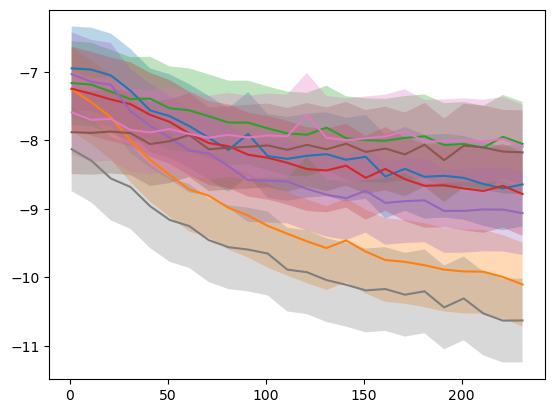

In [42]:
for l in range(len(q_mu_delta_l)):
    with torch.no_grad():
        z_mu, z_var = model.GP.cond_mu_cov(t_uni, t_uni, q_mu_delta_l[l], q_var_delta_l[l].squeeze())
        plt.plot(t_uni,z_mu)
        plt.fill_between(t_uni, y1=z_mu.squeeze()+1.96*z_var.diag().sqrt(), y2=z_mu.squeeze()-1.96*z_var.diag().sqrt(),alpha=0.3, label='1.96*std')
plt.show()  #

In [43]:
mu_s = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)

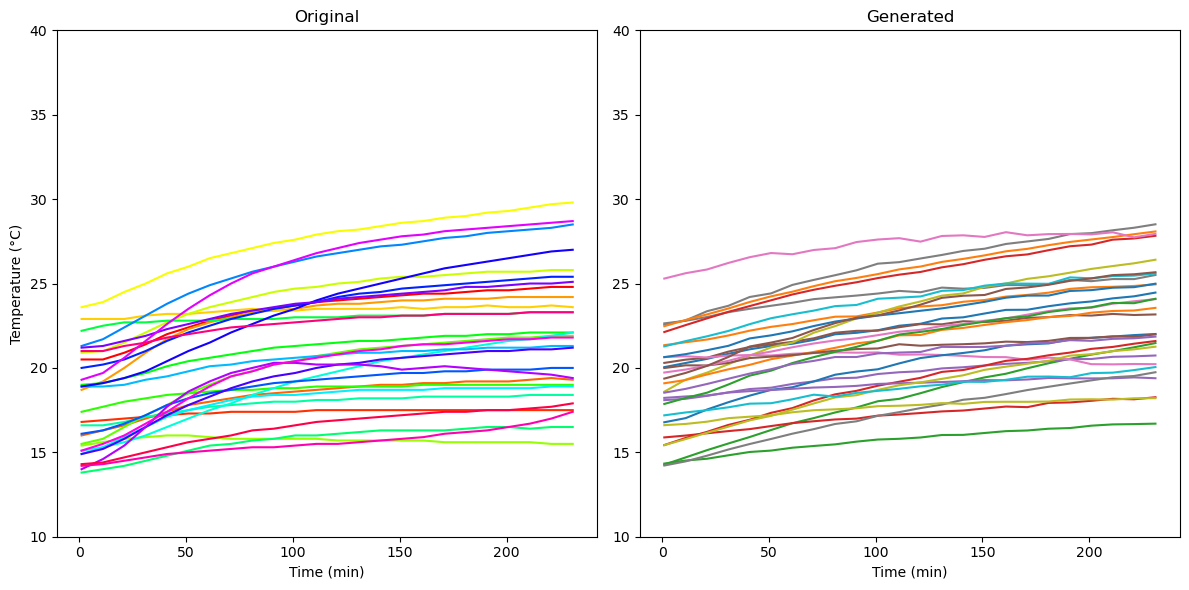

0.06766057293862104

In [44]:
total_size = len(dataset)
ns = total_size
min_T, max_T = 12, 25
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, generated_data, fig, axs=model.generate_and_plot(mu_s, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(10, 40),
                        plot=True,
                        seed=2
                       )
# Ts,T0,k_values
mmd_metric = tsgm.metrics.MMDMetric()
Gd = torch.stack(generated_data)
full_data = DataLoader(dataset)
original_data_list = []

# Iterate through the DataLoader
for batch in full_data:
    original_data_list.append(batch[0][:,0])

# Stack to create a tensor of shape [total_samples, 24, 1]
original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)
# Check the shape
# print(original_data.shape)
mmd_metric(original_data, Gd)

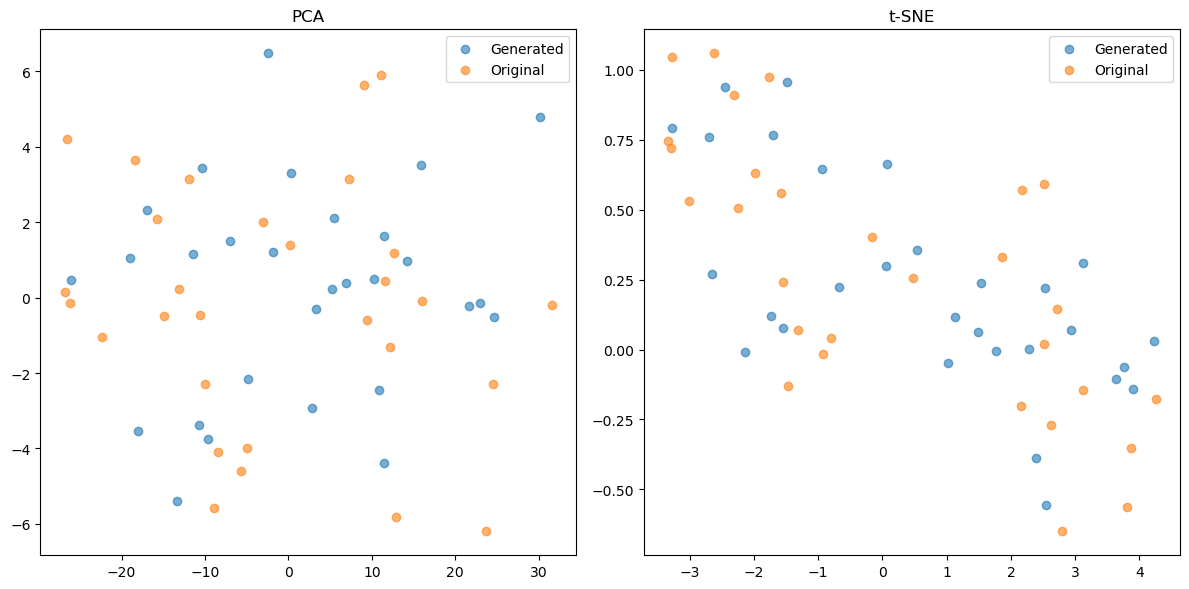

In [45]:

# Assume Gd and original_data are your generated and original data

# Reshape data to 2D format (num_samples, num_features)
Gd_reshaped = Gd.view(Gd.size(0), -1).numpy()
original_data_reshaped = original_data.view(original_data.size(0), -1).numpy()

# Concatenate generated and original data for visualization
data_combined = np.concatenate([Gd_reshaped, original_data_reshaped], axis=0)
labels = np.array(['Generated'] * Gd.size(0) + ['Original'] * original_data.size(0))

# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_combined)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for label in np.unique(labels):
    plt.scatter(pca_result[labels == label, 0], pca_result[labels == label, 1], label=label, alpha=0.6)
plt.title("PCA")

plt.legend()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_combined)

plt.subplot(1, 2, 2)
for label in np.unique(labels):
    plt.scatter(tsne_result[labels == label, 0], tsne_result[labels == label, 1], label=label, alpha=0.6)
plt.title("t-SNE")

plt.legend()

plt.tight_layout()
plt.show()

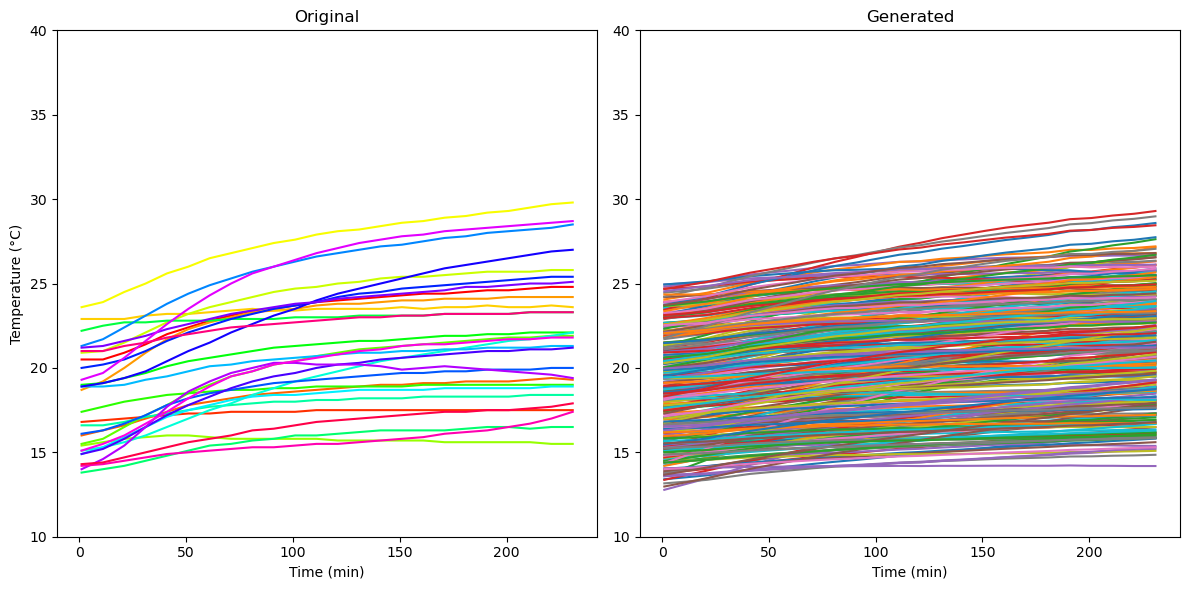

In [52]:
ns = 300
min_T, max_T = 12, 25
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, generated_data, fig, axs=model.generate_and_plot2(mu_s, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(10, 40),
                        plot=True,
                        seed=0
                       )

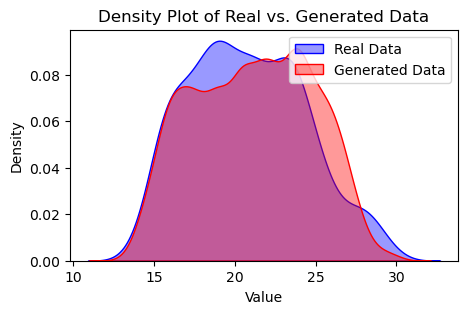

In [47]:
# Flatten the real and generated data to be one-dimensional
original_data_flattened = original_data.view(-1).numpy()
Gd = torch.stack(generated_data)
generated_data_flattened = Gd.view(-1).numpy()

# Plot overlapping density plots
plt.figure(figsize=(5, 3))
sns.kdeplot(original_data_flattened, label="Real Data", color="blue", fill=True, alpha=0.4)
sns.kdeplot(generated_data_flattened, label="Generated Data", color="red", fill=True, alpha=0.4)

# Customize plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Real vs. Generated Data')
plt.legend()
plt.show()


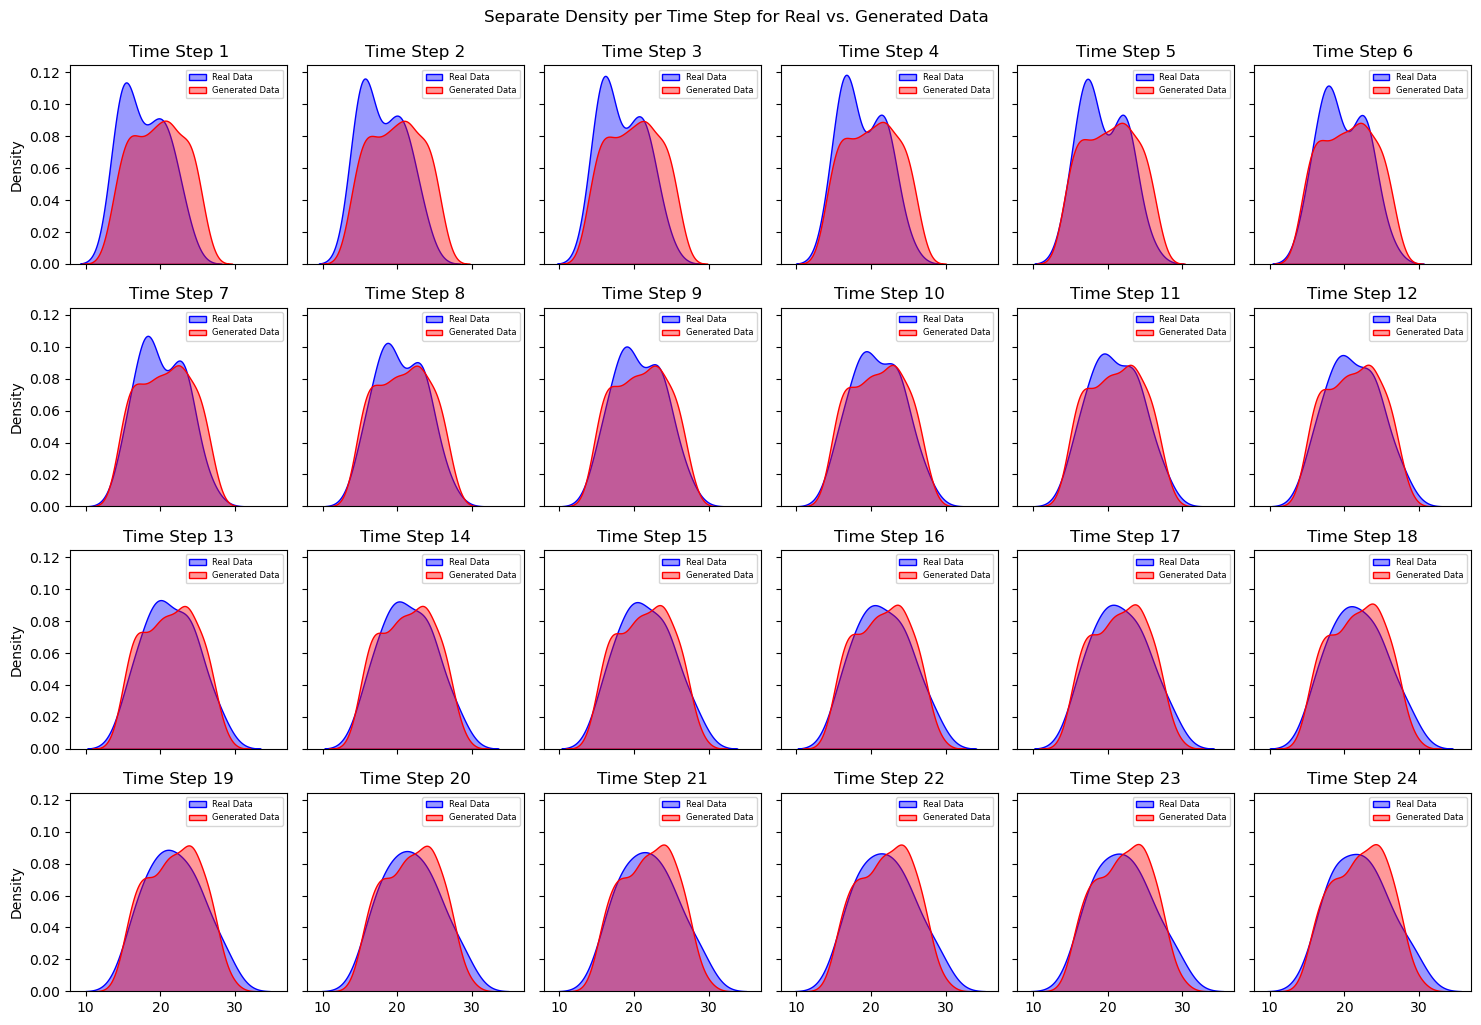

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for real and generated samples
original_data_windowed = original_data.view(total_size, 24).numpy()  # shape (28, 24)
generated_data_windowed = Gd.view(ns, 24).numpy()  # shape (ns, 24)

# Set up the number of subplots (one for each time step)
num_time_steps = 24
fig, axes = plt.subplots(4, 6, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each time step and plot density
for t in range(num_time_steps):
    # Extract the values at time step `t` for real and generated data
    real_values_at_t = original_data_windowed[:, t]
    generated_values_at_t = generated_data_windowed[:, t]
    
    # Plot density for real and generated data at each time step
    sns.kdeplot(real_values_at_t, ax=axes[t], label="Real Data", color="blue", fill=True, alpha=0.4)
    sns.kdeplot(generated_values_at_t, ax=axes[t], label="Generated Data", color="red", fill=True, alpha=0.4)
    
    # Label each subplot
    axes[t].set_title(f'Time Step {t + 1}')
    axes[t].legend(loc='upper right', fontsize=6)

# Adjust layout and add global labels
plt.tight_layout()
fig.suptitle('Separate Density per Time Step for Real vs. Generated Data', y=1.02)
plt.show()


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


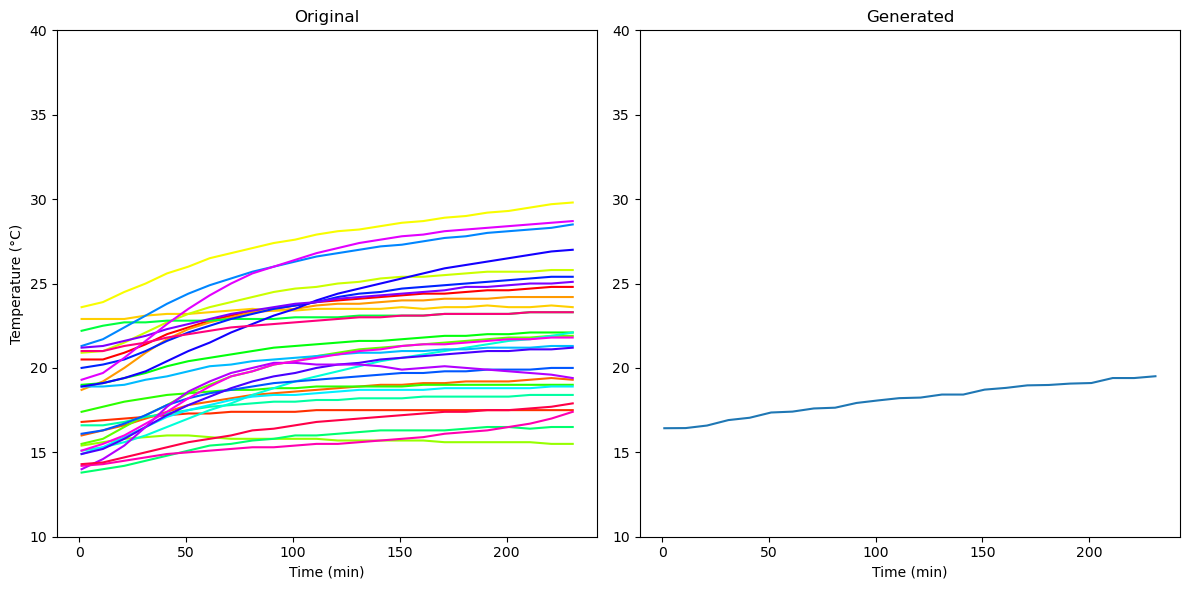

tensor([16.4751]) tensor([19.0246]) [0.6301368474960327]


In [49]:
ns = 1
min_T, max_T = 10, 25
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, generated_data, fig, axs=model.generate_and_plot(mu_s, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_h,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(10, 40),
                        plot=True
                       )
print(T0,Ts,k_values)


In [50]:
"""
from scipy.stats import lognorm
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean_q_mu_phy and mean_q_var_phy are PyTorch tensors
# Convert tensors to NumPy arrays or scalars
mean_q_mu_phy = [float(mu) for mu in mean_q_mu_phy]
mean_q_var_phy = [float(var) for var in mean_q_var_phy]

# Create the plot
plt.figure(figsize=(10, 6))

for i, (mean, variance) in enumerate(zip(mean_q_mu_phy, mean_q_var_phy)):
    std_dev = np.sqrt(variance)  # Standard deviation

    # Generate a range of x values for the lognormal distribution
    x = np.linspace(np.exp(mean - 4 * std_dev), np.exp(mean + 4 * std_dev), 1000)

    # Calculate the corresponding y values for the lognormal distribution
    y = lognorm.pdf(x, s=std_dev, scale=np.exp(mean))

    # Plot the lognormal distribution
    plt.plot(x, y, label=f"i={i}, μ={mean:.2f}, σ²={variance:.2f}")

plt.xlabel('k')
plt.ylabel('Probability Density')
plt.title('Posterior Distributions (Log-Normal)')
plt.grid(True)
# Uncomment the next line if you want to show the legend
# plt.legend()
plt.xlim(0, 4)
plt.show()

"""

'\nfrom scipy.stats import lognorm\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Assuming mean_q_mu_phy and mean_q_var_phy are PyTorch tensors\n# Convert tensors to NumPy arrays or scalars\nmean_q_mu_phy = [float(mu) for mu in mean_q_mu_phy]\nmean_q_var_phy = [float(var) for var in mean_q_var_phy]\n\n# Create the plot\nplt.figure(figsize=(10, 6))\n\nfor i, (mean, variance) in enumerate(zip(mean_q_mu_phy, mean_q_var_phy)):\n    std_dev = np.sqrt(variance)  # Standard deviation\n\n    # Generate a range of x values for the lognormal distribution\n    x = np.linspace(np.exp(mean - 4 * std_dev), np.exp(mean + 4 * std_dev), 1000)\n\n    # Calculate the corresponding y values for the lognormal distribution\n    y = lognorm.pdf(x, s=std_dev, scale=np.exp(mean))\n\n    # Plot the lognormal distribution\n    plt.plot(x, y, label=f"i={i}, μ={mean:.2f}, σ²={variance:.2f}")\n\nplt.xlabel(\'k\')\nplt.ylabel(\'Probability Density\')\nplt.title(\'Posterior Distributions (Log-Normal)\')\np

In [51]:
torch.save(model.state_dict(), 'pre_trained_models/PIGPVAE_heating.pth')